# __BIC (Bayesian Information Criteria) plot__

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr), Cécile Cabanes (cecile.cabanes@ifremer.fr) and Guillaume Maze (gmaze@ifremer.fr)
***

## Description

**The objective of this notebook is the calculation and plot of the BIC (Bayesian Information Criteria) to help you to find the optimal number of classes for your dataset.**

The BIC ([Bayesian Information Criteria](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) can be used to __optimize the number of classes__ in the PCM model, trying not to over-fit or under-fit the data. To compute this index, the model is fitted to the training dataset for a range of K values from 0 to 15. A __minimum__ in the BIC curve will give you the optimal number of classes to be used.

This notebook is a complement of the classification notebook *Classif_ArgoReferenceDatabase.ipynb*.

***
This notebook has been developed at the Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Euro-ArgoRISE project. This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: Individual support to ESFRI and other world-class research infrastructures.

<div>
<center>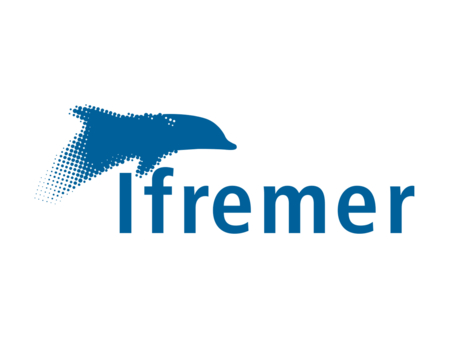 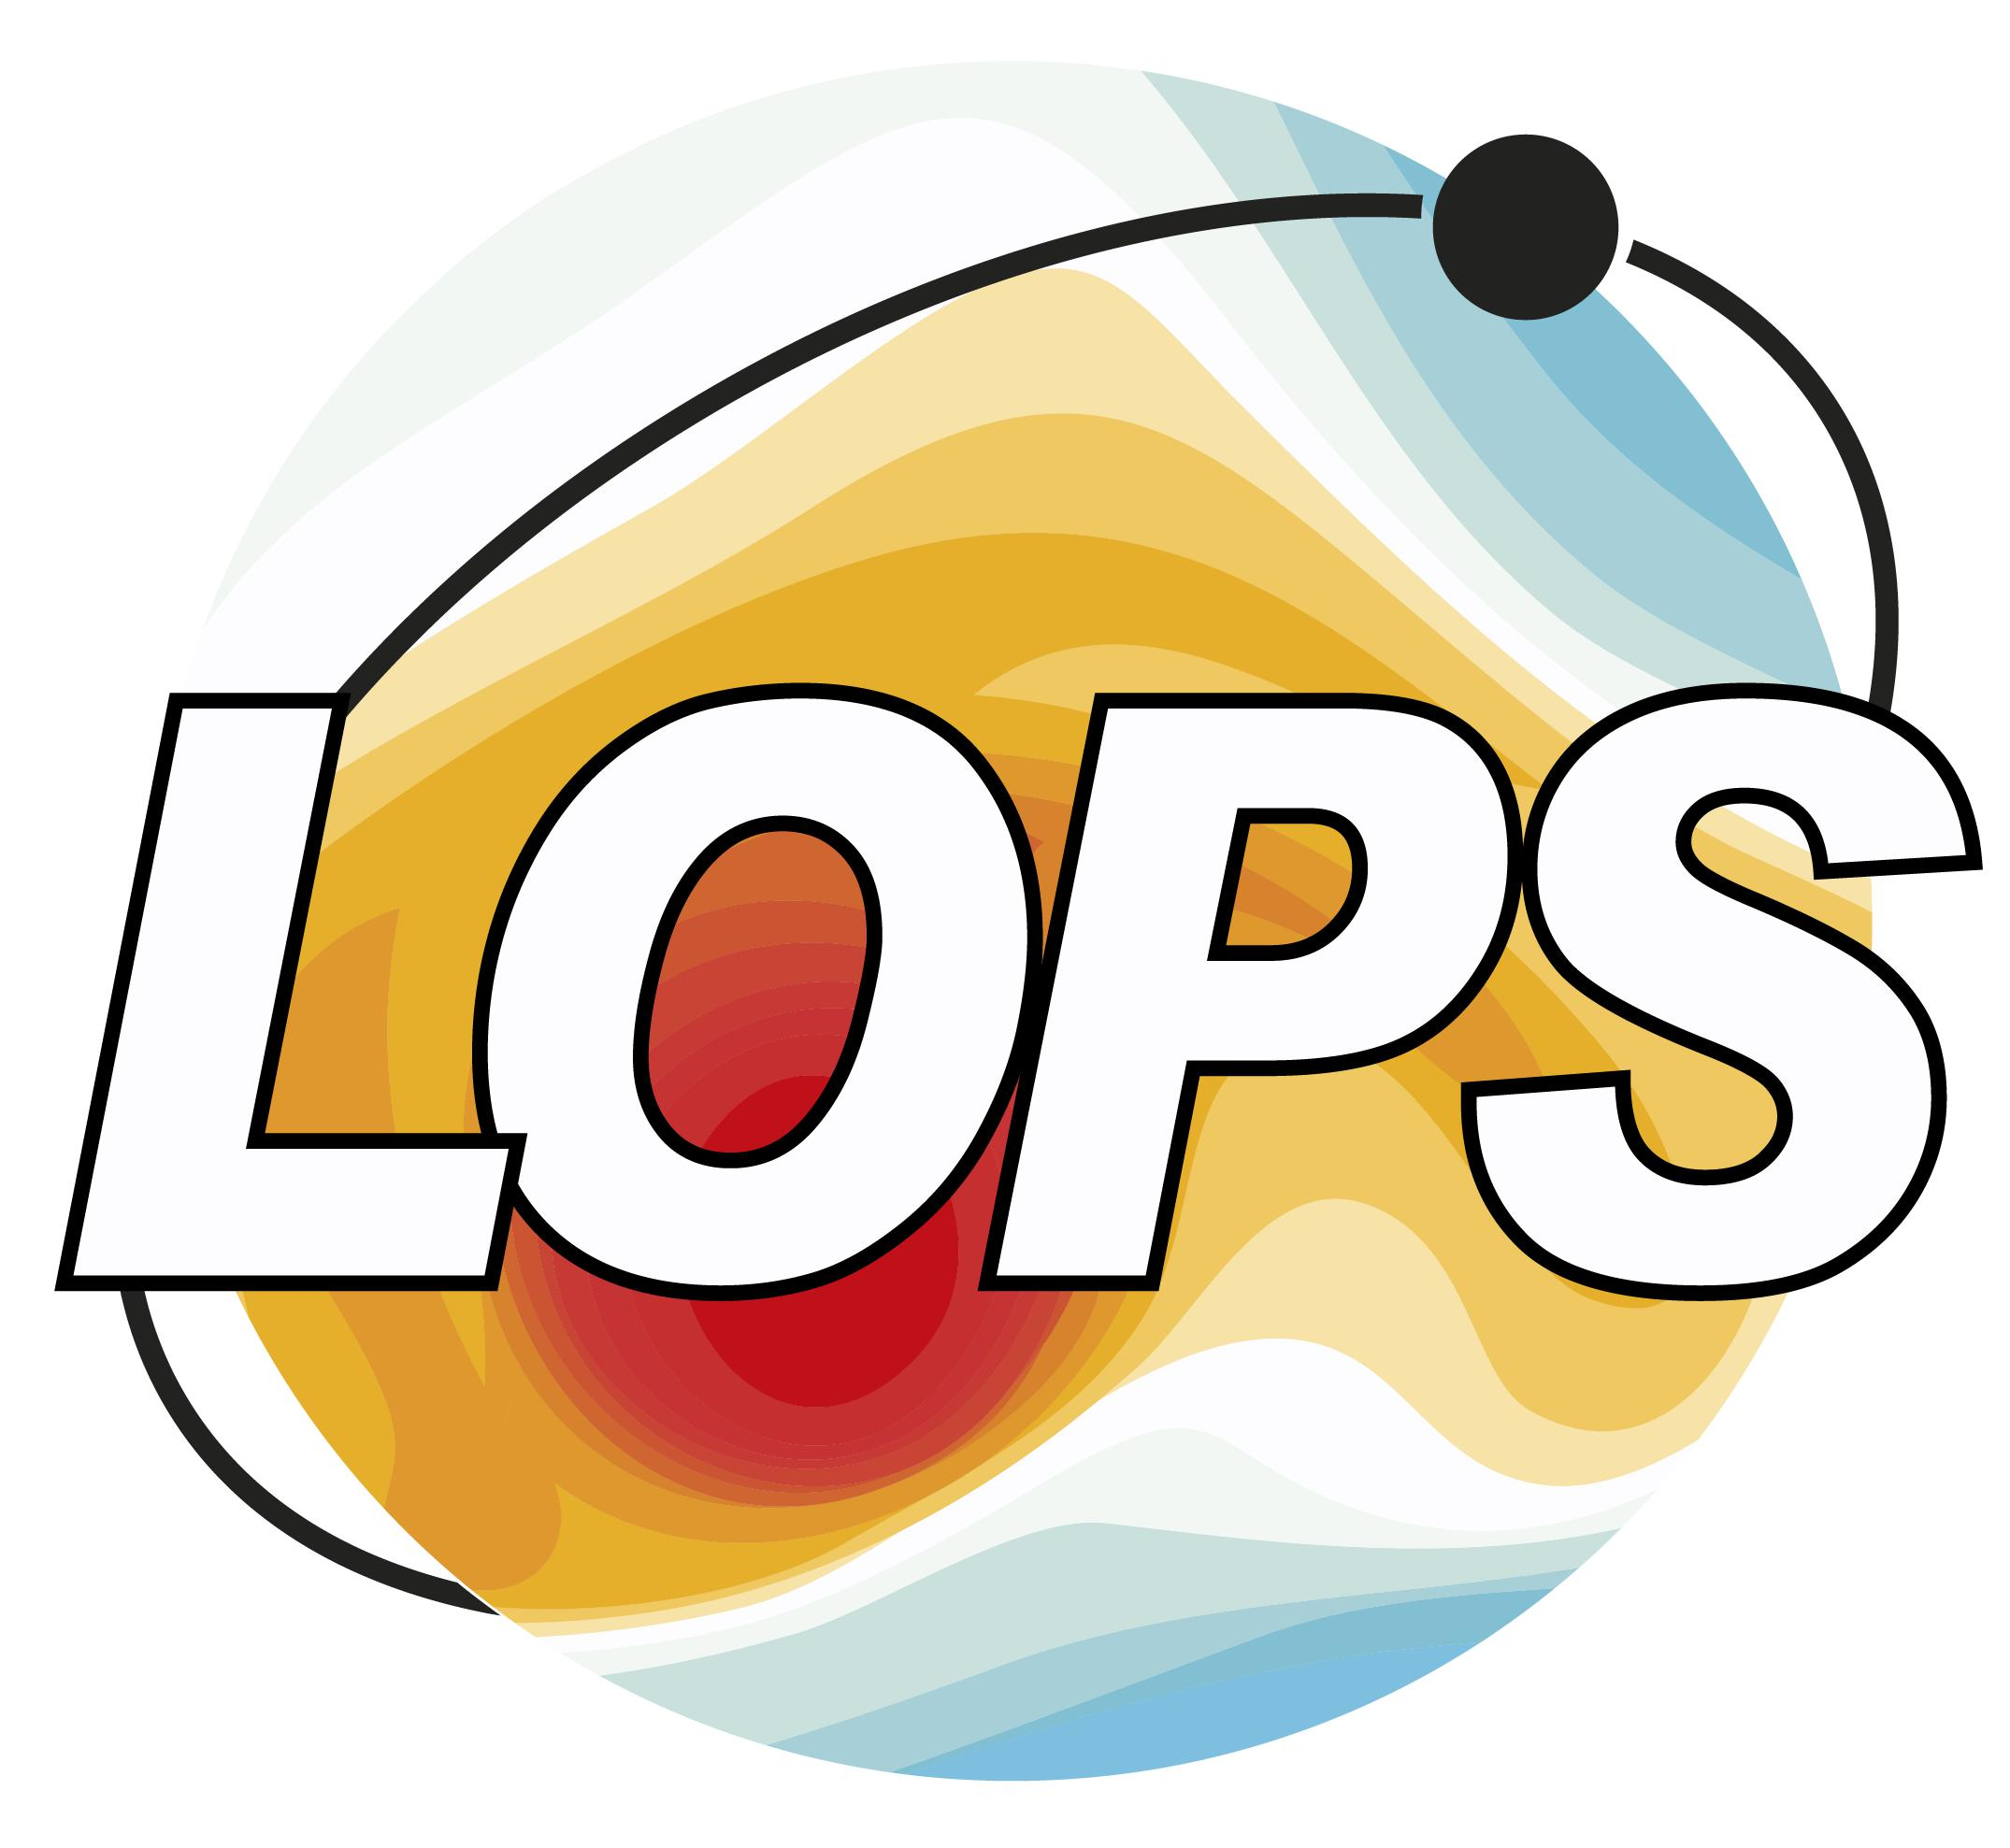 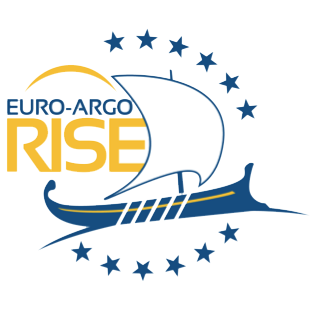</center>
</div>

In [1]:
import xarray as xr
import numpy as np

import PCM_utils_forDMQC as pcm_utils

import configparser

## User inputs
***

__Configuration file__

You should provide the path to the **OWC configuration file** (*ow_config.txt*). The information used to select the profiles from the Argo reference database came from this file (``MAPSCALE_LONGITUDE_LARGE`` and ``MAPSCALE_LATITUDE_LARGE``). You can find the most suitable OWC configuration parameters for you float in the DMQC cookbook ([*Cabanes et al, 2021*](https://archimer.ifremer.fr/doc/00678/78994/)). The paths to the Argo reference database directory and the float data are read in the *ow_config.txt* file as well.

In [2]:
config_filename = '/home6/homedir10/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

__Interpolation depth__

The PCM can not deal with NaN values, so the reference dataset is interpolated on standard depth levels and the profiles shallower than the **max_depth**, defined below, are dropped out. A max depth of 1000m can be enough, however you should find a compromise between keeping a sufficient number of reference profiles and having a comprehensive representation of the oceanography in the region. You should also consider the depth of the float profiles: if they are shallower than the max depth, they will be dropped out, and they will not be classified by the PCM. In such cases, a lower value of max depth is recommended.

In [3]:
max_depth = 1000

__Float reference number__

You should provide the **WMO number** of the float you want to correct in OWC. We propose to you 3 examples (explained in the deliverable, link), float 4900136 crossing the Gulf Stream, float 3901928 in the Southern Ocean and float 3901915 in the Agulhas Current. We encourage you to try your own floats!

In [4]:
# Gulf Stream 
#float_WMO = 4900136
# Southern ocean
#float_WMO = 3901928
# Agulhas Current
float_WMO = 3901915
# Galicia
#float_WMO = 6900230

## Load argo reference database
***

Important paths are read in the OWC configuration file and data is loaded from the Argo reference database.

__Read OWC configuration file__

In [5]:
with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

Three paths are automatically assigned from the OW configuration file:

- ***wmo_boxes_argo.mat*** file path, to determine if you use Argo data, CTD data or both as reference dataset (as in OWC, see [DMQC cookbook](https://archimer.ifremer.fr/doc/00678/78994/))
- path to the **Argo reference database**
- float source directory, where we will find the *.mat* file containing the **float data**. If you have not created the .mat file yet, you can generate it using the last version of argopy (link to argopy and example of function).

You can change the automatic paths below, if needed.

In [6]:
wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
ref_path = config['historical_directory']
float_mat_path = config['float_source_directory'] + str(float_WMO)+ '.mat'

__Load argo reference database__

Data is selected in the same way as OWC does: **ellipses** using the longitude and latitude scales defined in the OWC configuration file are constructed around each float profile. The ``map_pv_use`` option makes the selection taking into account the bathymetrie.

In [7]:
ds = pcm_utils.get_refdata(float_mat_path = float_mat_path,  
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3100.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3200.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3300.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3400.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3500.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3101.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3201.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3301.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3401.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3501.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3302.mat
/home5/pharos/argo/DMARGO/OW/VER

In [ ]:
print(ds)

__Interpolate to standard levels__

The dataset `ds` is interpolated on standard depth levels and the profiles shallower than the **max_depth** are dropped out.

In [8]:
ds = pcm_utils.interpolate_standard_levels(ds, std_lev=np.arange(0,max_depth))

/home6/homedir10/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/PCM_utils_forDMQC/data_processing.py:123: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [9]:
print(ds)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 17914)
Coordinates:
    long               (n_profiles) float64 9.577 9.848 9.281 ... 358.6 358.5
    lat                (n_profiles) float64 -26.74 -25.99 ... -40.89 -41.49
    dates              (n_profiles) datetime64[ns] 2005-03-09T19:53:38 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 18387 18388 18389 18390
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.49 ... 34.25
    source             (n_profiles) object '1900165_078.BRECKOWENS' ... '6902...
    temp               (n_profiles, PRES_INTERPOLATED) float64 22.23 ... 3.394
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


Quick plot of the profiles in `ds`.

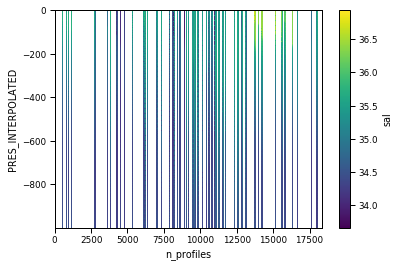

In [10]:
ds['sal'].plot(x='n_profiles');

Plot of the **spatial distribution** of the reference dataset `ds`.

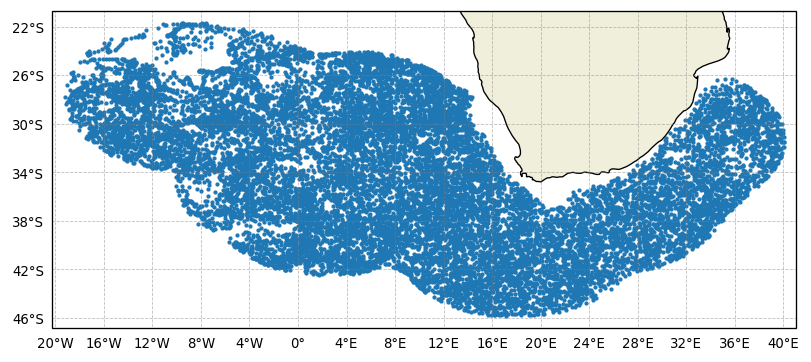

In [11]:
pcm_utils.plot_spatialdist_ds(ds, float_WMO, float_traj=False)

## BIC plot
***

The BIC ([Bayesian Information Criteria](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) can be used to __optimize the number of classes__ in the model, trying not to over-fit or under-fit the data. To compute this index, the model is fitted to the training dataset for a range of K values from 0 to 15. A __minimum__ in the BIC curve will give you the optimal number of classes to be used.

Moreover, for each K range run, a subset of the training dataset is randomly selected in order to use *independent* profiles. Indeed, the ocean exhibits spatial correlations that reduce the real information contained in the training dataset. This has to be taken into account. The dataset is sub-sampled into several subsets of uncorrelated profiles, finally allowing us to compute several times each K range run and hence to compute a standard deviation on the BIC metric.

The spatial correlation scale to consider is determined by the user, regarding his/her knowledge of the region.

You can also choose the number of runs and the maximum number of classes, taking into account that increasing these numbers will increase the computation time. 

__User input__

In [12]:
corr_dist = 50 # correlation distance in km
Nrun = 10 # number of runs for each k
NK = 15 # max number of classes to explore

__BIC calculation__

Calculation can take some minutes to run.

In [13]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

In [14]:
%%time
BIC, BIC_min = pcm_utils.BIC_calculation(ds=ds, corr_dist=corr_dist,
                                         pcm_features=pcm_features, features_in_ds=features_in_ds, z_dim=z_dim, 
                                         Nrun=Nrun, NK=NK)

run 1/10
run 2/10
run 3/10
run 4/10
run 5/10
run 6/10
run 7/10
run 8/10
run 9/10
run 10/10
CPU times: user 24min 43s, sys: 40min 11s, total: 1h 4min 55s
Wall time: 9min 29s


__BIC plot__

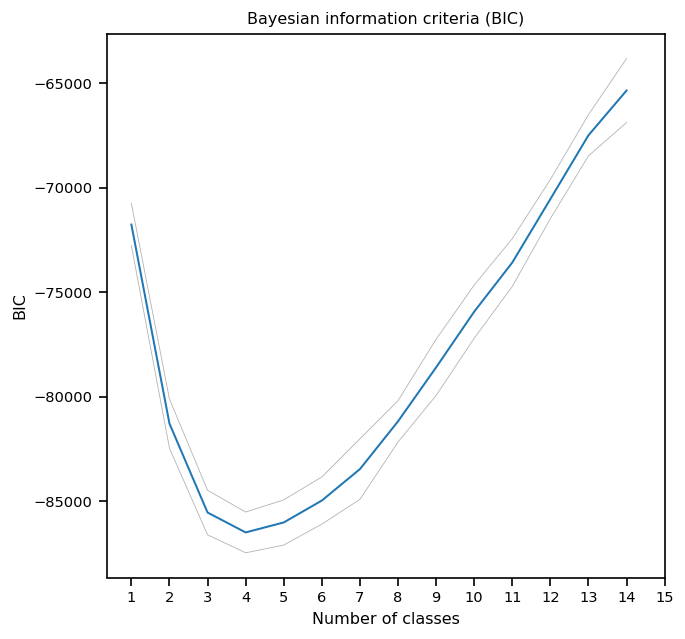

In [15]:
pcm_utils.plot_BIC(BIC=BIC, NK=NK)

In [16]:
BIC_min

4

The BIC curve may not show a clear minimum. This can be an indication that some profiles remained correlated in the training set, so try to adjust more precisely the correlation scale.

If the BIC curve has a clear minimum, don't forget to take into account the standard deviation. The BIC curve indicates a statistical optimum, so if the minimum is not above the standard deviation range, then it is indicative of an optimal **range** rather than a precise value. In this case, use your expertise to choose the number of classes (within the BIC allowed range) leading to ocean patterns that simply make the most sense to you.